In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### **get dateset from google drive**

In [0]:
file_id = '1wj5EXCBZ9wyzxYoyHk3XHuvV2ZZSTGAb' #Maryam
#file_id = '1C_QrXpJ2Tlgz96H_V_rRzQTJY7hyy4sp' #Zahra
#file_id = '1QHq13EfkJHYWhve0-zh_IAQ1U5GDCIoX' #Tahere
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('fer2013.csv') 

### **import requirements**

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras import backend as K
import keras
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras import optimizers
from sklearn.metrics import confusion_matrix
import itertools
from google.colab import files
import h5py
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2
from keras.layers import SeparableConv2D
import scipy as sc

### **load the dateset into a dataframe**

In [10]:
df = pd.DataFrame.from_csv('fer2013.csv', index_col=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


### split dataset

In [11]:
train = df[0:28709]
cv = df[28709:32298]
test = df[32298:]
y_train = train.emotion
y_cv = cv.emotion

num_pix = 2304 #48*48
num_classes = 7
train_size = train.shape[0]
cv_size = cv.shape[0]
cv_size

3589

### **split pixels and convert data to 3d (3 channels)**

In [12]:
X_train = np.zeros((train_size, 64, 64, 3))
for i in range (train_size):
  b = [int(j) for j in train.pixels[i].split()]
  b = np.array(b).reshape([48,48]) 
  b = sc.misc.imresize(b, [64, 64])
  X_train[i,:,:,0] = X_train[i,:,:,1] = X_train[i,:,:,2] = b
  #b.reshape([140, 140, 1])

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [13]:
X_cv = np.zeros((cv_size, 64, 64, 3))
for i in range (train_size, train_size+cv_size):
    b = [int(j) for j in cv.pixels[i].split()]
    b = np.array(b).reshape([48,48]) 
    b = sc.misc.imresize(b, [64, 64])
    X_cv[i - train_size, :, :, 0] = X_cv[i - train_size, :, :, 1] = X_cv[i - train_size, :, :, 2] = b
    #b.reshape([140, 140, 1])

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [14]:
X_cv.shape

(3589, 64, 64, 3)

In [0]:
# Normalize image vectors
X_train = X_train/255.
X_cv = X_cv/255.
num_classes = 7
# Convert training and test labels to one hot matrices
#y_train = convert_to_one_hot(y_cv, 7).T
#y_cv = convert_to_one_hot(y_cv, 7).T
y_train = keras.utils.to_categorical(y_train, num_classes)
y_cv = keras.utils.to_categorical(y_cv, num_classes)

In [16]:
input_shape = (64, 64, 3)
print(X_train.shape[0], 'train samples')
print(X_cv.shape[0], 'test samples')

28709 train samples
3589 test samples


### **implement minixception CNN**

In [0]:
l2_regularization = 0.01
regularization = l2(l2_regularization)
regularization = l2(l2_regularization)

# base
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                        use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                        use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2),
                  padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(16, (3, 3), padding='same',
                    kernel_regularizer=regularization,
                    use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same',
                    kernel_regularizer=regularization,
                    use_bias=False)(x)
x = BatchNormalization()(x)

x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2),
                  padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(32, (3, 3), padding='same',
                    kernel_regularizer=regularization,
                    use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same',
                    kernel_regularizer=regularization,
                    use_bias=False)(x)
x = BatchNormalization()(x)

x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),
                  padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(64, (3, 3), padding='same',
                    kernel_regularizer=regularization,
                    use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',
                    kernel_regularizer=regularization,
                    use_bias=False)(x)
x = BatchNormalization()(x)

x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),
                  padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(128, (3, 3), padding='same',
                    kernel_regularizer=regularization,
                    use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',
                    kernel_regularizer=regularization,
                    use_bias=False)(x)
x = BatchNormalization()(x)

x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

x = Conv2D(num_classes, (3, 3),
        kernel_regularizer=regularization,
        padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)

model = Model(img_input, output)

In [39]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 62, 62, 8)    216         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 62, 62, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 62, 62, 8)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
import os, glob, time
epoch_num = 0
outputFolder = './output-xception'
file_ini = outputFolder+'/weights-'+ str(epoch_num)+'*'
filename =  glob.glob(file_ini)

In [0]:

outputFolder = './output-xception/'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/weights-{epoch:02d}-{val_acc:.2f}.h5"

### **define some callbacks like model checkpoint and early stopping**

In [0]:
# earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
#                           verbose=1, mode='auto')
# callbacks_list = [earlystop]

In [0]:
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, \
                             save_best_only=False, save_weights_only=False,\
                             mode='auto', period=10)
callbacks_list = [checkpoint]

### **train the model**

In [24]:
# model_info = model.fit(X_train, y_train, 
#          batch_size=128,
#          epochs= 100,
#          #callbacks=callbacks_list,              
#          verbose=1,
#          #validation_data=(X_cv, y_cv))
model_info = model.fit(X_train, y_train, batch_size=32, \
                       epochs=100, callbacks=callbacks_list, verbose=1, \
                        initial_epoch = epoch_num+1, validation_data=(X_cv, y_cv))

Train on 28709 samples, validate on 3589 samples
Epoch 2/100
28709/28709 [==============================] - 66s 2ms/step - loss: 1.7971 - acc: 0.3694 - val_loss: 2.1294 - val_acc: 0.3667
Epoch 3/100
28709/28709 [==============================] - 62s 2ms/step - loss: 1.4719 - acc: 0.4787 - val_loss: 1.4855 - val_acc: 0.4692
Epoch 4/100
28709/28709 [==============================] - 62s 2ms/step - loss: 1.3291 - acc: 0.5214 - val_loss: 1.5699 - val_acc: 0.4386
Epoch 5/100
28709/28709 [==============================] - 61s 2ms/step - loss: 1.2450 - acc: 0.5524 - val_loss: 1.4707 - val_acc: 0.4575
Epoch 6/100
28709/28709 [==============================] - 62s 2ms/step - loss: 1.1922 - acc: 0.5723 - val_loss: 1.6061 - val_acc: 0.4500
Epoch 7/100
28709/28709 [==============================] - 62s 2ms/step - loss: 1.1489 - acc: 0.5880 - val_loss: 1.4464 - val_acc: 0.5038
Epoch 8/100
28709/28709 [==============================] - 61s 2ms/step - loss: 1.1119 - acc: 0.5989 - val_loss: 1.2971 - v

### **accuracy of the model**

In [25]:
score = model.evaluate(X_cv, y_cv, verbose = 0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  1.9607405347656692
Test accuracy:  0.5664530509974373


In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### **plot accuracy per epoch**

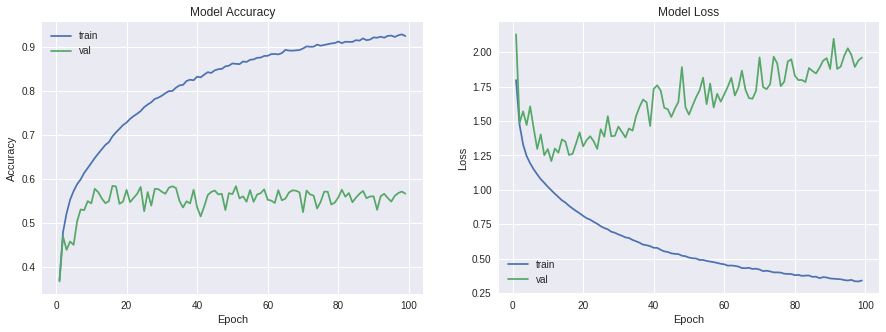

In [30]:
plot_model_history(model_info)

In [0]:
y_pred = model.predict(X_cv)

In [0]:
#(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

### **plot the confusion matrix of the train data**

Confusion matrix, without normalization
[[215   3  51  45  62  22  69]
 [ 17  19   3   1   8   1   7]
 [ 67   1 147  42  92  56  91]
 [ 21   1  19 723  23  32  76]
 [ 72   3  61  79 268  21 149]
 [ 12   1  32  20   7 318  25]
 [ 44   3  44  72  79  22 343]]
Normalized confusion matrix
[[0.46 0.01 0.11 0.1  0.13 0.05 0.15]
 [0.3  0.34 0.05 0.02 0.14 0.02 0.12]
 [0.14 0.   0.3  0.08 0.19 0.11 0.18]
 [0.02 0.   0.02 0.81 0.03 0.04 0.08]
 [0.11 0.   0.09 0.12 0.41 0.03 0.23]
 [0.03 0.   0.08 0.05 0.02 0.77 0.06]
 [0.07 0.   0.07 0.12 0.13 0.04 0.57]]


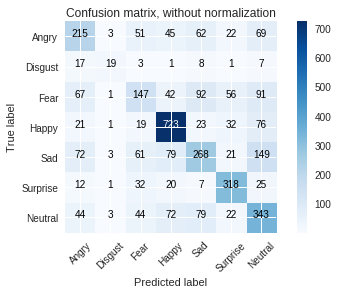

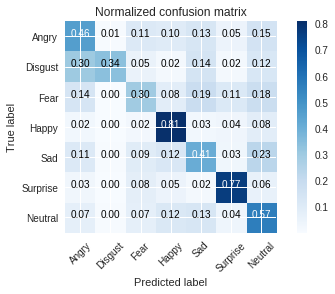

In [33]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_cv.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
y_pred = model.predict(X_train)

### **plot the confusion matrix of the test data**

Confusion matrix, without normalization
[[3269    6   82  202  121   75  240]
 [  48  337   12   18   10    5    6]
 [ 156    6 3186  133  212  173  231]
 [  11    1   14 7005   21   45  118]
 [ 140    9  119  158 3943   38  423]
 [  17    1   35   80    8 2991   39]
 [  32    1   29  127   69   21 4686]]
Normalized confusion matrix
[[8.18e-01 1.50e-03 2.05e-02 5.06e-02 3.03e-02 1.88e-02 6.01e-02]
 [1.10e-01 7.73e-01 2.75e-02 4.13e-02 2.29e-02 1.15e-02 1.38e-02]
 [3.81e-02 1.46e-03 7.78e-01 3.25e-02 5.17e-02 4.22e-02 5.64e-02]
 [1.52e-03 1.39e-04 1.94e-03 9.71e-01 2.91e-03 6.24e-03 1.64e-02]
 [2.90e-02 1.86e-03 2.46e-02 3.27e-02 8.16e-01 7.87e-03 8.76e-02]
 [5.36e-03 3.15e-04 1.10e-02 2.52e-02 2.52e-03 9.43e-01 1.23e-02]
 [6.45e-03 2.01e-04 5.84e-03 2.56e-02 1.39e-02 4.23e-03 9.44e-01]]


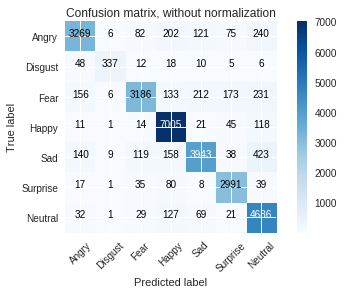

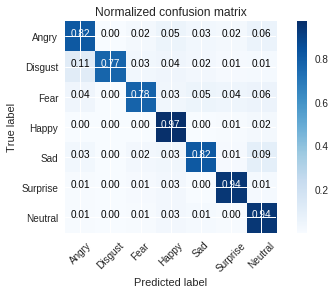

In [35]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()